# 🤗 Training with Diffusers

In recent months, it has become clear that diffusion models have taken the throne as the state-of-the-art generative models. Here, we will use Hugging Face's brand new [Diffusers](https://github.com/huggingface/diffusers) library to train a simple diffusion model. 

## Installing the dependencies

This notebook leverages the [🤗 Datasets](https://huggingface.co/docs/datasets/index) library to load and preprocess image datasets and the [🤗 Accelerate](https://huggingface.co/docs/accelerate/index) library to simplify training on any number of GPUs, with features like automatic gradient accumulation and tensorboard logging. Let's install them here:

In [1]:
!nvidia-smi

Fri Nov 25 07:15:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!pip install diffusers[training]==0.5.1
!pip install "ipywidgets>=7,<8"

As google colab has disabled external widgtes, we need to enable it explicitly. Run the following cell to be able to use `notebook_login` and `tqdm`:

In [4]:
#from google.colab import output
#output.enable_custom_widget_manager()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd "/content/gdrive/MyDrive/DL Project/"

/content/gdrive/.shortcut-targets-by-id/1wi9vgavoChaiKzvd4yqdbBeMVY8Gujox/DL Project


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community, there are a few more steps to follow.|

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your **write** token:

In [5]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful



Then you need to install Git-LFS to upload your model checkpoints:

In [6]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [7]:
!unzip skewed_shrunk_bw.zip -d /content/data

Streaming output truncated to the last 5000 lines.
 extracting: /content/data/skewed/data/Training/pituitary/Tr-pi_1311.jpg  
 extracting: /content/data/skewed/data/Training/pituitary/Tr-pi_0966.jpg  
 extracting: /content/data/skewed/data/Training/pituitary/Tr-pi_0549.jpg  
  inflating: /content/data/skewed/data/Training/pituitary/Tr-pi_0761.jpg  
  inflating: /content/data/skewed/data/Training/pituitary/Tr-pi_0565.jpg  
 extracting: /content/data/skewed/data/Training/pituitary/Tr-pi_0290.jpg  
  inflating: /content/data/skewed/data/Training/pituitary/Tr-pi_0520.jpg  
  inflating: /content/data/skewed/data/Training/pituitary/Tr-pi_0231.jpg  
 extracting: /content/data/skewed/data/Training/pituitary/Tr-pi_0733.jpg  
  inflating: /content/data/skewed/data/Training/pituitary/Tr-pi_1146.jpg  
 extracting: /content/data/skewed/data/Training/pituitary/Tr-pi_0492.jpg  
  inflating: /content/data/skewed/data/Training/pituitary/Tr-pi_0718.jpg  
 extracting: /content/data/skewed/data/Training/p

In [8]:
cd /content

/content


In [9]:
class_name = 'notumor'

## Config

For convenience, we define a configuration grouping all the training hyperparameters. This would be similar to the arguments used for a [training script](https://github.com/huggingface/diffusers/tree/main/examples).
Here we choose reasonable defaults for hyperparameters like `num_epochs`, `learning_rate`, `lr_warmup_steps`, but feel free to adjust them if you train on your own dataset. For example, `num_epochs` can be increased to 100 for better visual quality.

In [10]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10
    output_dir = f'cancer_diffusion_model_{class_name}'
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [11]:
#img_dir = os.path.join("/content/drive/My Drive/DL Project/data/skewed/Training/", "pituitary")

In [12]:
#print(os.path.join(img_dir, 'Tr-pi_' + '0000' + '.jpg'))

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download our image dataset.

In this case, the [Butterflies dataset](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) is hosted remotely, but you can load a local [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) as shown in the commets below. 

In [13]:
import os

root_dir = "/content/data/skewed/data/Training/"
dir_types = ['pituitary', 'glioma', 'notumor', 'meningioma']
files = {}
for dir_type in dir_types:  
  files[dir_type] = []
for dir_type in dir_types:
  files[dir_type] = [os.path.join(root_dir, dir_type, filename) for filename in os.listdir(os.path.join(root_dir, dir_type))]


In [14]:
from datasets import Dataset, Image
tumor_dataset = Dataset.from_dict({"image": files[class_name]}).cast_column("image", Image())
config.dataset_name = class_name


The dataset contains several extra `features` (columns), but the one that we're interested in is `image`:

Since the [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) feature loads the images with PIL, we can easily look at a few examples:

In [15]:
print(tumor_dataset[0])


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7F09CEFA0890>}


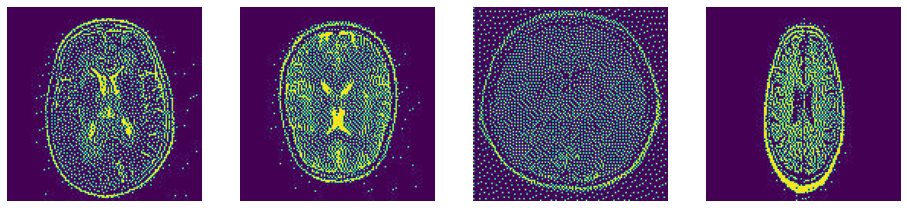

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(tumor_dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [17]:
!nvidia-smi

Fri Nov 25 07:17:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The images in the dataset are all different, so we need to preprocess them first:
* `Resize` makes the images conform to a square resolution of `config.image_size`
* `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
* `Normalize` is important to rescale the pixel values into a `[-1, 1]` range (which our model will expect).

In [18]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [19]:
tumor_dataset[:4]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7F094D486190>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7F094D486250>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7F094D486310>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7F094D4863D0>]}

🤗 Datasets offer a handy `set_transform()` method to apply the image transformations on the fly during training:

In [20]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"image": images}

tumor_dataset.set_transform(transform)

Let's see what they look like now

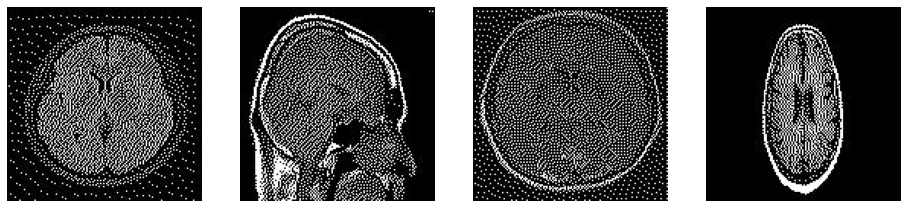

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(tumor_dataset[4:8]["image"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

Now that all our images have the same size and are converted to tensors, we can create the dataloader we will use for training.

In [22]:
import torch

train_dataloader = torch.utils.data.DataLoader(tumor_dataset, batch_size=config.train_batch_size, shuffle=True)

## Defining the diffusion model

Here we set up our diffusion model. Diffusion models are neural networks that are trained to predict slightly less noisy images from a noisy input. At inference, they can be used to iteratively transform a random noise to generate an image:

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Don't worry too much about the math if you're not familiar with it, the import part to remember is that our model corresponds to the arrow $p_{\theta}(x_{t-1}|x_{t})$ (which is a fancy way of saying: predict a slightly less noisy image).

The interesting part is that it's really easy to add some noise to an image, so the training can happen in a semi-supervised fashion as follows:
1. Take an image from the training set.
2. Apply to it some random noise $t$ times (this will give the $x_{t-1}$ and the $x_{t}$ in the figure above).
3. Give this noisy image to the model along with the value of $t$.
4. Compute a loss from the output of the model and the noised image $x_{t-1}$.

Then we can apply gradient descent and repeat this process multiple times.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downample path to the corresponsding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size. 
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):


In [23]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

Let's get a sample image from our dataset and pass it into our model. We just need to add a batch dimension:

In [24]:
#sample_image = pituitary_dataset[0]['image'].unsqueeze(0)
#print('Input shape:', sample_image.shape)

And let's check the output is a tensor of the same exact shape:

In [25]:
#print('Output shape:', model(sample_image, timestep=0).sample.shape)

Great!

Note that our model takes in the (noisy) image and also the current time-step (as we saw before in the training overview). That time-step information is converted for the model using a sinusoidal positional embedding, similar to what Transformer models often do.

Now that we have our model, we just need an object to *add noise to an image*. This is done by the **schedulers** in the `diffusers` library.

## Defining the noise scheduler

Depending on the diffusion algorithm you want to use, the way images are noised is slightly different. That's why 🤗 Diffusers contains different scheduler classes which each define the algorithm-specific diffusion steps. Here we are going to use the `DDPMScheduler` which corresponds to the training denoising and training algorithm proposed in [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239).

In [26]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Let's see how this noise scheduler works: it takes a batch of images from the trainng set (here we will reuse the batch of one image `sample_image` form before), a batch of random noise of the same shape and the timesteps for each image (which correspond to the number of times we want to apply noise to each image):

In [27]:
import torch
from PIL import Image

#noise = torch.randn(sample_image.shape)
#timesteps = torch.LongTensor([50])
#noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

#Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In the DDPM algorithm, the training objective of the model is then to be able to predict the noise we used in `noise_scheduler.add_noise`, so the loss at this step would be:

In [28]:
import torch.nn.functional as F

#noise_pred = model(noisy_image, timesteps).sample
#loss = F.mse_loss(noise_pred, noise)

## Setting up training

We have all we need to be able to train our model! Let's use a standard AdamW optimizer:

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

 And a cosine learning rate schedule:

In [30]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

To evaluate our model, we use the `DDPMPipeline` which is an easy way to perform end-to-end inference (see this notebook [TODO link] for more detail). We will use this pipeline to generate a batch of sample images and save it as a grid to the disk. 

In [31]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

def get_images(config, epoch, batch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = 16, 
        generator=torch.manual_seed(batch),
    ).images

    # Make a grid out of the images
    #image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    for i,img in enumerate(images):
      img.save(f"{test_dir}/{epoch:04d}_{batch}_{i}.png")

In [32]:
model.cuda()

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (c

With this in end, we can group all together and write our training function. This just wraps the training step we saw in the previous section in a loop, using Accelerate for easy TensorBoard logging, gradient accumulation, mixed precision training and multi-GPUs or TPU training.

In [34]:
from accelerate import Accelerator
from diffusers.hub_utils import init_git_repo, push_to_hub

from tqdm.auto import tqdm
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo = init_git_repo(config, at_init=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['image']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                get_images(config, epoch, 1, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    push_to_hub(config, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir) 

## Let's train!

Let's launch the training (including multi-GPU training) from the notebook using Accelerate's `notebook_launcher` function:

In [35]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


Cloning https://huggingface.co/emendes3/cancer_diffusion_model_notumor into local empty directory.


Download file unet/diffusion_pytorch_model.bin:   0%|          | 16.0k/434M [00:00<?, ?B/s]

Download file logs/train_example/events.out.tfevents.1669313766.a88bceb8332e.77.0:   3%|3         | 16.0k/496k…

Download file logs/train_example/events.out.tfevents.1669308895.fafa198ab703.79.0:  13%|#2        | 16.0k/124k…

Download file samples/0009.png: 100%|##########| 842/842 [00:00<?, ?B/s]

Clean file samples/0009.png: 100%|##########| 842/842 [00:00<?, ?B/s]

Clean file samples/0019.png: 100%|##########| 842/842 [00:00<?, ?B/s]

Clean file samples/0029.png: 100%|##########| 842/842 [00:00<?, ?B/s]

Clean file samples/0039.png: 100%|##########| 842/842 [00:00<?, ?B/s]

Clean file logs/train_example/events.out.tfevents.1669308895.fafa198ab703.79.0:   1%|          | 1.00k/124k [0…

Clean file logs/train_example/events.out.tfevents.1669313766.a88bceb8332e.77.0:   0%|          | 1.00k/496k [0…

Clean file unet/diffusion_pytorch_model.bin:   0%|          | 1.00k/434M [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0009_1_0.png', 'samples/0009_1_1.png', 'samples/0009_1_10.png', 'samples/0009_1_11.png', 'samples/0009_1_12.png', 'samples/0009_1_13.png', 'samples/0009_1_14.png', 'samples/0009_1_15.png', 'samples/0009_1_2.png', 'samples/0009_1_3.png', 'samples/0009_1_4.png', 'samples/0009_1_5.png', 'samples/0009_1_6.png', 'samples/0009_1_7.png', 'samples/0009_1_8.png', 'samples/0009_1_9.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.34k/434M [00:00<?, ?B/s]

Upload file samples/0009_1_6.png:   9%|8         | 3.34k/38.5k [00:00<?, ?B/s]

Upload file samples/0009_1_14.png:   9%|8         | 3.34k/38.6k [00:00<?, ?B/s]

Upload file samples/0009_1_0.png:   8%|8         | 3.34k/39.6k [00:00<?, ?B/s]

Upload file samples/0009_1_3.png:   9%|8         | 3.34k/39.0k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1669360856.3aa93afffb7f.74.0:   3%|2         | 3.34k/124k […

Upload file samples/0009_1_2.png:   9%|8         | 3.34k/38.5k [00:00<?, ?B/s]

Upload file samples/0009_1_8.png:   9%|8         | 3.34k/38.5k [00:00<?, ?B/s]

Upload file samples/0009_1_5.png:   9%|8         | 3.34k/38.5k [00:00<?, ?B/s]

Upload file samples/0009_1_15.png:   9%|8         | 3.34k/38.5k [00:00<?, ?B/s]

Upload file samples/0009_1_1.png:   9%|8         | 3.34k/38.4k [00:00<?, ?B/s]

Upload file samples/0009_1_10.png:   9%|8         | 3.34k/38.2k [00:00<?, ?B/s]

Upload file samples/0009_1_4.png:   9%|8         | 3.34k/38.2k [00:00<?, ?B/s]

Upload file samples/0009_1_9.png:   9%|8         | 3.34k/38.0k [00:00<?, ?B/s]

Upload file samples/0009_1_7.png:   9%|8         | 3.34k/37.9k [00:00<?, ?B/s]

Upload file samples/0009_1_13.png:   9%|8         | 3.34k/37.8k [00:00<?, ?B/s]

Upload file samples/0009_1_11.png:   9%|8         | 3.34k/37.6k [00:00<?, ?B/s]

Upload file samples/0009_1_12.png:   9%|8         | 3.34k/37.6k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   8c67a41..1b7b9d9  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   8c67a41..1b7b9d9  main -> main

To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   1b7b9d9..4ffb972  main -> main

   1b7b9d9..4ffb972  main -> main



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0019_1_0.png', 'samples/0019_1_1.png', 'samples/0019_1_10.png', 'samples/0019_1_11.png', 'samples/0019_1_12.png', 'samples/0019_1_13.png', 'samples/0019_1_14.png', 'samples/0019_1_15.png', 'samples/0019_1_2.png', 'samples/0019_1_3.png', 'samples/0019_1_4.png', 'samples/0019_1_5.png', 'samples/0019_1_6.png', 'samples/0019_1_7.png', 'samples/0019_1_8.png', 'samples/0019_1_9.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.34k/434M [00:00<?, ?B/s]

Upload file samples/0019_1_1.png:  10%|9         | 3.34k/34.5k [00:00<?, ?B/s]

Upload file samples/0019_1_3.png:   9%|9         | 3.34k/35.4k [00:00<?, ?B/s]

Upload file samples/0019_1_0.png:   9%|9         | 3.34k/35.7k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1669360856.3aa93afffb7f.74.0:   1%|1         | 3.34k/248k […

Upload file samples/0019_1_4.png:  10%|9         | 3.34k/34.0k [00:00<?, ?B/s]

Upload file samples/0019_1_14.png:  10%|9         | 3.34k/34.4k [00:00<?, ?B/s]

Upload file samples/0019_1_2.png:  10%|9         | 3.34k/34.0k [00:00<?, ?B/s]

Upload file samples/0019_1_13.png:  10%|9         | 3.34k/34.0k [00:00<?, ?B/s]

Upload file samples/0019_1_10.png:  10%|9         | 3.34k/33.6k [00:00<?, ?B/s]

Upload file samples/0019_1_15.png:  10%|9         | 3.34k/33.5k [00:00<?, ?B/s]

Upload file samples/0019_1_8.png:  10%|9         | 3.34k/33.5k [00:00<?, ?B/s]

Upload file samples/0019_1_12.png:  10%|#         | 3.34k/33.4k [00:00<?, ?B/s]

Upload file samples/0019_1_6.png:  10%|#         | 3.34k/33.2k [00:00<?, ?B/s]

Upload file samples/0019_1_9.png:  10%|#         | 3.34k/33.0k [00:00<?, ?B/s]

Upload file samples/0019_1_5.png:  10%|#         | 3.34k/32.6k [00:00<?, ?B/s]

Upload file samples/0019_1_7.png:  11%|#         | 3.34k/31.2k [00:00<?, ?B/s]

Upload file samples/0019_1_11.png:  11%|#         | 3.34k/31.1k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   4ffb972..55c17eb  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   4ffb972..55c17eb  main -> main



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0029_1_0.png', 'samples/0029_1_1.png', 'samples/0029_1_10.png', 'samples/0029_1_11.png', 'samples/0029_1_12.png', 'samples/0029_1_13.png', 'samples/0029_1_14.png', 'samples/0029_1_15.png', 'samples/0029_1_2.png', 'samples/0029_1_3.png', 'samples/0029_1_4.png', 'samples/0029_1_5.png', 'samples/0029_1_6.png', 'samples/0029_1_7.png', 'samples/0029_1_8.png', 'samples/0029_1_9.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.34k/434M [00:00<?, ?B/s]

Upload file samples/0029_1_9.png:  10%|#         | 3.34k/32.4k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1669360856.3aa93afffb7f.74.0:   1%|          | 3.34k/372k […

Upload file samples/0029_1_3.png:  10%|#         | 3.34k/32.7k [00:00<?, ?B/s]

Upload file samples/0029_1_13.png:  10%|#         | 3.34k/32.9k [00:00<?, ?B/s]

Upload file samples/0029_1_0.png:  10%|#         | 3.34k/32.8k [00:00<?, ?B/s]

Upload file samples/0029_1_4.png:  10%|#         | 3.34k/32.3k [00:00<?, ?B/s]

Upload file samples/0029_1_6.png:  10%|#         | 3.34k/32.4k [00:00<?, ?B/s]

Upload file samples/0029_1_1.png:  10%|#         | 3.34k/32.3k [00:00<?, ?B/s]

Upload file samples/0029_1_14.png:  10%|#         | 3.34k/32.2k [00:00<?, ?B/s]

Upload file samples/0029_1_10.png:  10%|#         | 3.34k/32.2k [00:00<?, ?B/s]

Upload file samples/0029_1_12.png:  10%|#         | 3.34k/32.0k [00:00<?, ?B/s]

Upload file samples/0029_1_2.png:  10%|#         | 3.34k/32.0k [00:00<?, ?B/s]

Upload file samples/0029_1_5.png:  10%|#         | 3.34k/32.0k [00:00<?, ?B/s]

Upload file samples/0029_1_8.png:  11%|#         | 3.34k/31.7k [00:00<?, ?B/s]

Upload file samples/0029_1_15.png:  11%|#         | 3.34k/31.7k [00:00<?, ?B/s]

Upload file samples/0029_1_7.png:  11%|#         | 3.34k/31.0k [00:00<?, ?B/s]

Upload file samples/0029_1_11.png:  11%|#         | 3.34k/30.6k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   55c17eb..93f034f  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   55c17eb..93f034f  main -> main



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0039_1_0.png', 'samples/0039_1_1.png', 'samples/0039_1_10.png', 'samples/0039_1_11.png', 'samples/0039_1_12.png', 'samples/0039_1_13.png', 'samples/0039_1_14.png', 'samples/0039_1_15.png', 'samples/0039_1_2.png', 'samples/0039_1_3.png', 'samples/0039_1_4.png', 'samples/0039_1_5.png', 'samples/0039_1_6.png', 'samples/0039_1_7.png', 'samples/0039_1_8.png', 'samples/0039_1_9.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.34k/434M [00:00<?, ?B/s]

Upload file samples/0039_1_14.png:  11%|#         | 3.34k/31.1k [00:00<?, ?B/s]

Upload file samples/0039_1_1.png:  11%|#         | 3.34k/31.4k [00:00<?, ?B/s]

Upload file samples/0039_1_13.png:  10%|#         | 3.34k/31.8k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1669360856.3aa93afffb7f.74.0:   1%|          | 3.34k/496k […

Upload file samples/0039_1_0.png:  11%|#         | 3.34k/31.7k [00:00<?, ?B/s]

Upload file samples/0039_1_2.png:  11%|#         | 3.34k/31.3k [00:00<?, ?B/s]

Upload file samples/0039_1_3.png:  10%|#         | 3.34k/32.1k [00:00<?, ?B/s]

Upload file samples/0039_1_4.png:  11%|#         | 3.34k/31.1k [00:00<?, ?B/s]

Upload file samples/0039_1_10.png:  11%|#         | 3.34k/31.0k [00:00<?, ?B/s]

Upload file samples/0039_1_15.png:  11%|#         | 3.34k/30.9k [00:00<?, ?B/s]

Upload file samples/0039_1_9.png:  11%|#         | 3.34k/30.9k [00:00<?, ?B/s]

Upload file samples/0039_1_12.png:  11%|#         | 3.34k/30.8k [00:00<?, ?B/s]

Upload file samples/0039_1_8.png:  11%|#         | 3.34k/30.5k [00:00<?, ?B/s]

Upload file samples/0039_1_6.png:  11%|#         | 3.34k/30.5k [00:00<?, ?B/s]

Upload file samples/0039_1_5.png:  11%|#1        | 3.34k/30.0k [00:00<?, ?B/s]

Upload file samples/0039_1_7.png:  11%|#1        | 3.34k/29.2k [00:00<?, ?B/s]

Upload file samples/0039_1_11.png:  12%|#1        | 3.34k/28.6k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   93f034f..edb1804  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   93f034f..edb1804  main -> main



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0049_1_0.png', 'samples/0049_1_1.png', 'samples/0049_1_10.png', 'samples/0049_1_11.png', 'samples/0049_1_12.png', 'samples/0049_1_13.png', 'samples/0049_1_14.png', 'samples/0049_1_15.png', 'samples/0049_1_2.png', 'samples/0049_1_3.png', 'samples/0049_1_4.png', 'samples/0049_1_5.png', 'samples/0049_1_6.png', 'samples/0049_1_7.png', 'samples/0049_1_8.png', 'samples/0049_1_9.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.34k/434M [00:00<?, ?B/s]

Upload file samples/0049_1_1.png:  11%|#         | 3.34k/30.4k [00:00<?, ?B/s]

Upload file samples/0049_1_0.png:  11%|#         | 3.34k/31.3k [00:00<?, ?B/s]

Upload file samples/0049_1_2.png:  11%|#1        | 3.34k/30.3k [00:00<?, ?B/s]

Upload file samples/0049_1_3.png:  11%|#         | 3.34k/31.2k [00:00<?, ?B/s]

Upload file samples/0049_1_13.png:  11%|#         | 3.34k/30.8k [00:00<?, ?B/s]

Upload file samples/0049_1_4.png:  11%|#         | 3.34k/30.4k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1669360856.3aa93afffb7f.74.0:   1%|          | 3.34k/620k […

Upload file samples/0049_1_14.png:  11%|#1        | 3.34k/30.2k [00:00<?, ?B/s]

Upload file samples/0049_1_15.png:  11%|#1        | 3.34k/30.2k [00:00<?, ?B/s]

Upload file samples/0049_1_8.png:  11%|#1        | 3.34k/29.8k [00:00<?, ?B/s]

Upload file samples/0049_1_12.png:  11%|#1        | 3.34k/29.6k [00:00<?, ?B/s]

Upload file samples/0049_1_5.png:  11%|#1        | 3.34k/29.1k [00:00<?, ?B/s]

Upload file samples/0049_1_9.png:  11%|#1        | 3.34k/29.1k [00:00<?, ?B/s]

Upload file samples/0049_1_10.png:  12%|#1        | 3.34k/28.8k [00:00<?, ?B/s]

Upload file samples/0049_1_6.png:  12%|#1        | 3.34k/28.0k [00:00<?, ?B/s]

Upload file samples/0049_1_7.png:  12%|#2        | 3.34k/27.0k [00:00<?, ?B/s]

Upload file samples/0049_1_11.png:  13%|#2        | 3.34k/26.6k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   edb1804..08709dc  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/emendes3/cancer_diffusion_model_notumor
   edb1804..08709dc  main -> main



In [ ]:
accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps, 
    log_with="tensorboard",
    logging_dir=os.path.join(config.output_dir, "logs")
)
pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
for i in range (2, 10):
  get_images(config, 30, i, pipeline)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
!zip -r /content/images_10.zip f'/content/cancer_diffusion_model_{class_name}/samples'

In [ ]:
from google.colab import files
files.download("/content/images_10.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps, 
    log_with="tensorboard",
    logging_dir=os.path.join(config.output_dir, "logs")
)
pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
for i in range (11, 19):
  get_images(config, 30, i, pipeline)

TypeError: ignored

In [36]:
!zip -r /content/images_19.zip f'/content/cancer_diffusion_model_{class_name}/samples'

	zip warning: name not matched: f/content/cancer_diffusion_model_notumor/samples

zip error: Nothing to do! (try: zip -r /content/images_19.zip . -i f/content/cancer_diffusion_model_notumor/samples)


In [37]:
from google.colab import files
files.download("/content/images_19.zip")

FileNotFoundError: ignored

In [ ]:
accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps, 
    log_with="tensorboard",
    logging_dir=os.path.join(config.output_dir, "logs")
)
pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
for i in range (30, 43):
  get_images(config, 30, i, pipeline)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(i)

24


In [ ]:
!zip -r /content/images_43.zip f'/content/cancer_diffusion_model_{class_name}/samples'

In [ ]:
from google.colab import files
files.download("/content/images_43.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
len(os.listdir("/content/cancer_diffusion_model_pituitary/samples"))

471

Let's have a look at the final image grid produced by the trained diffusion model:

Not bad! There's room for improvement of course, so feel free to play with the hyperparameters, model definition and image augmentations 🤗

If you've chosen to upload the model to the Hugging Face Hub, its repository should now look like so: 
https://huggingface.co/anton-l/ddpm-butterflies-128

If you want to dive deeper into the code, we also have more advanced training scripts with features like Exponential Moving Average of model weights here: 

https://github.com/huggingface/diffusers/tree/main/examples